In [1]:
# load packages and functions
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(cowplot))
suppressMessages(library(data.table))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(ggpointdensity))
suppressMessages(library(ggpubr))
suppressMessages(library(ggrepel))
suppressMessages(library(ggsci))
suppressMessages(library(ggthemes))
suppressMessages(library(gridExtra))
suppressMessages(library(ggpmisc))
suppressMessages(library(Hmisc))
suppressMessages(library(magrittr))
suppressMessages(library(patchwork))
suppressMessages(library(pROC))
suppressMessages(library(RColorBrewer))
suppressMessages(library(stringr))
suppressMessages(library(tidyverse))


# cluster annotation
cluster_df = read.table("/projects/jinamo@xsede.org/cytof/data/cluster_annotation.txt",sep="\t",header=TRUE) %>%
    dplyr::mutate(cluster = as.character(cluster))

In [2]:
# meta data
meta<- read.table("/projects/jinamo@xsede.org/cytof/data/RA_AtRiskRA_Control_meta.txt",sep="\t",header=TRUE, na.strings=c("","NA")) %>%
    dplyr::mutate(age_at_biopsy = as.integer(age_at_biopsy),
                  diagnosis = factor(diagnosis, levels=c("Control","AtRiskRA","RA")))
meta_add = read.table("/projects/jinamo@xsede.org/cytof/data/meta_clinical_RA.txt", header = TRUE, sep = "\t") %>%
  dplyr::mutate(CDAI = as.numeric(CDAI),
                subject_id = gsub("-","_",subject_id),
                treatment = dplyr::case_when(
                  treatment == "1" ~ "naive",
                  treatment == "2" ~ "MTX failure",
                  treatment == "3" ~ "TNF failure",
                  treatment == "4" ~ "OA"
                )) %>%
  dplyr::select(-c(sex,age))

meta_add2 = read.table("/projects/jinamo@xsede.org/cytof/data/clinical_data_for_FAN_from_Kat.txt", header = TRUE, sep = "\t") %>%
  dplyr::select(-c(sex))

meta_add3 = read.table("/projects/jinamo@xsede.org/cytof/data/RA_Cleaned_aggregate_vars.txt", header = TRUE, sep = "\t") %>%
  dplyr::select(c(subject_id,HAQ,das28_crp3,bmi,ra_group,pathotype_str,sdai,ccp_type,ccp_range,rf_range,mdtjc28_sum,mdsjc28_sum,criteria_2010_score,heart___1,lung___1,thyroid___1,ibd___1,psoriasis___1,comorb_none___1,alcohol,diabetes,MTX,SSZ,HCQ,LEF,TNFi,ra_group,pathotype_str))

meta_add4 = read.csv("/projects/jinamo@xsede.org/cytof/data/B_All_MD.csv", header = TRUE) %>%
    dplyr::mutate(subject_id = stringr::str_split(file, pattern="_", simplify=TRUE)[,3] %>% 
                                    stringr::str_split(., pattern="\\-V", simplify=TRUE) %>%
                                    as.data.frame() %>%
                                    .[,1] %>%
                                    gsub("-","_",.)) %>%
    dplyr::rename(time_point = Visit) %>%
    dplyr::select(c(time_point,subject_id,CDAI)) %>%
    tidyr::pivot_wider(names_from = time_point, values_from = CDAI) %>%
    .[,c("subject_id","V0","V1","V2")] %>%
    magrittr::set_colnames(c("subject_id","CDAI_V0","CDAI_V1","CDAI_V2")) %>%
    dplyr::arrange(subject_id)
meta_total = read.csv("/projects/jinamo@xsede.org/cytof/data/Total_Metadata.csv", header = TRUE) %>%
    dplyr::mutate(subject_id = gsub("-","_",Patient)) %>%
    dplyr::distinct(subject_id,.keep_all = TRUE)


Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


In [3]:

# calculate proportion of each cluster in each major cell population

# set parameters
n_min = 10000
frac = 0.90

for (CELL in c("B_cells","NK_cells","T_cells","myeloid")){
  
  print(CELL)
  # parameter for UMAP
    if (CELL == "B_cells"){  
        prop = 1
        n_neighbors=30
        min_dist=0.01
        resolution_list=0.5
    } else if (CELL == "T_cells"){  
        prop = 0.1
        n_neighbors=30
        min_dist=0.01
        resolution_list=0.7
    } else if (CELL == "NK_cells"){  
        prop = 1
        n_neighbors=30
        min_dist=0.01
        resolution_list=0.3
    } else if (CELL == "myeloid"){    
        prop = 0.1
        n_neighbors=30
        min_dist=0.01
        resolution_list=0.3
    }
    
  umap_res <- readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/",CELL,"/umap_Prop",prop,"_Nmin",n_min,"_topVar",frac,"_nneighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,".rds"))
  # remove clusters less than cut off
  min_cell_cluster = 30
  clu = umap_res %>%
    dplyr::group_by(res_cell) %>%
    dplyr::summarize(count = dplyr::n()) %>%
    dplyr::arrange(count) %>%
    dplyr::filter(count > min_cell_cluster) %>%
    .$res_cell %>%
    unique()
  clu_logi = umap_res$res_cell %in% clu
  umap_res = umap_res[clu_logi,]
  
  if (CELL %in% c("B_cells","T_cells","myeloid")){
    batch_fl = readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/",CELL,"/meta_Prop",prop,"_Nmin",n_min,".rds"))
    batch_fl$subject_id <- stringr::str_split(batch_fl$OmiqFileIndex, pattern="_", simplify=TRUE)[,3] %>% 
      stringr::str_split(., pattern="\\-V", simplify=TRUE) %>%
      as.data.frame() %>%
      .[,1] %>%
      gsub("-","_",.)
    batch_fl = batch_fl[clu_logi,]
  } else if (CELL %in% c("NK_cells")){  
    batch_fl = readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/",CELL,"/meta_Prop",prop,"_Nmin",n_min,".rds"))
    batch_fl$subject_id <- stringr::str_split(batch_fl$OmiqFileIndex, pattern="_", simplify=TRUE)[,2] %>% 
      stringr::str_split(., pattern="\\-V", simplify=TRUE) %>%
      as.data.frame() %>%
      .[,1] %>%
      gsub("-","_",.)
    batch_fl = batch_fl[clu_logi,]
  }
  
  tmp = cbind(cluster = umap_res$res_cell,batch_fl) %>%
    dplyr::group_by(subject_id,time_point,cluster) %>%
    dplyr::summarize(count = dplyr::n()) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(subject_id,time_point) %>%
    dplyr::mutate(proportion = 100*count/sum(count),
                  subject_timepoint = paste(subject_id,time_point,sep="__")) %>%
    merge(.,
          batch_fl[,c("subject_id","disease")] %>%
            unique(),
          by = "subject_id") %>%
    dplyr::arrange(subject_id,cluster)
  for (ind in unique(tmp$subject_timepoint)){
    # print(paste0(grep(ind,unique(tmp$subject_id)),"/",length(unique(tmp$subject_id))))
    tmp_ind = tmp[tmp$subject_timepoint == ind,]
    for (clu in unique(umap_res$res_cell)[order(as.integer(unique(umap_res$res_cell)))]){
      # print(clu)
      if (nrow(tmp_ind[tmp_ind$cluster == clu,])==0){
        tmp = tmp %>% dplyr::add_row(subject_id = unique(tmp_ind$subject_id), subject_timepoint = ind, time_point = unique(tmp_ind$time_point), cluster = clu, count = 0, proportion = 0, disease = unique(tmp_ind$disease))
      }
    }
  }
  tmp = tmp %>% dplyr::arrange(subject_id,time_point,cluster) %>% dplyr::mutate(cluster = paste0(CELL,"_cluster",cluster), cell = ifelse(CELL %in% c("B_cells","NK_cells","T_cells"), gsub("_cells","",CELL),"M"))
  
  if (CELL == "B_cells"){
    df = tmp
  } else {
    df = rbind(tmp,df)
  }
  
}



[1] "B_cells"


`summarise()` has grouped output by 'subject_id', 'time_point'. You can
override using the `.groups` argument.


[1] "NK_cells"


`summarise()` has grouped output by 'subject_id', 'time_point'. You can
override using the `.groups` argument.


[1] "T_cells"


`summarise()` has grouped output by 'subject_id', 'time_point'. You can
override using the `.groups` argument.


[1] "myeloid"


`summarise()` has grouped output by 'subject_id', 'time_point'. You can
override using the `.groups` argument.


In [4]:
## proportion of each major cell type
cell_prop = readRDS("/projects/jinamo@xsede.org/cytof/data/major_cell_type_abundance.rds") 
cell_prop %<>%
    dplyr::mutate(subject_timepoint = rownames(.),
                  subject_id = stringr::str_split(subject_timepoint,pattern="__",simplify=TRUE) %>% .[,1],
                  time_point = stringr::str_split(subject_timepoint,pattern="__",simplify=TRUE) %>% .[,2]) %>%
    dplyr::rename(B = `B cell/plasma cell`,
                  M = `Myeloid`,
                  T = `T cell`) %>%
    tidyr::pivot_longer(-c(subject_timepoint,subject_id,time_point)) %>%
    magrittr::set_colnames(c("subject_timepoint","subject_id","time_point","cell_type","prop")) %>%
    dplyr::mutate(prop = 100*prop)
head(cell_prop,30)
dim(cell_prop)

subject_timepoint,subject_id,time_point,cell_type,prop
<chr>,<chr>,<chr>,<chr>,<dbl>
200_0272__V0,200_0272,V0,B,4.497198
200_0272__V0,200_0272,V0,M,43.488421
200_0272__V0,200_0272,V0,NK,3.053823
200_0272__V0,200_0272,V0,T,48.960558
200_0275__V0,200_0275,V0,B,8.397157
200_0275__V0,200_0275,V0,M,13.159292
200_0275__V0,200_0275,V0,NK,2.090155
200_0275__V0,200_0275,V0,T,76.353396
200_0276__V0,200_0276,V0,B,6.473128


[1] 772   5

In [5]:
# calculate correlation based on abundance per each cell type, not per all leukocytes
df %<>%
    dplyr::select(-c(subject_id,time_point)) %>%
    dplyr::left_join(.,cell_prop,by="subject_timepoint") %>%
    dplyr::filter(cell_type == cell) %>%
    dplyr::select(-c(cell,prop))

In [6]:
# transform to wide data frame
df_wide = df %>%
    dplyr::select(-c(count,cell_type)) %>%
    tidyr::pivot_wider(names_from = cluster, values_from = proportion) %>%
    dplyr::left_join(.,meta,by="subject_id") %>%
    dplyr::left_join(.,meta_add,by="subject_id") %>%
    dplyr::left_join(.,meta_add2,by="subject_id") %>%
    dplyr::left_join(.,meta_add3,by="subject_id") %>%
    dplyr::left_join(.,meta_add4,by="subject_id") %>%
    dplyr::mutate_at(vars(matches("^(B_cells|NK_cells|T_cells|myeloid)_cluster.*")), ~replace_na(.,0)) %>%
    dplyr::arrange(subject_timepoint)
df_wide$AtRisk = dplyr::case_when(
  df_wide$AMP_Group == "FDR" & df_wide$CCP == "Positive" ~ "FDR(+)/ACPA(+)",
  df_wide$AMP_Group == "GP" & df_wide$CCP == "Positive" ~ "FDR(-)/ACPA(+)",
  df_wide$AMP_Group == "FDR" & df_wide$CCP == "Negative" ~ "FDR(+)/ACPA(-)",
  df_wide$AMP_Group == "GP" & df_wide$CCP == "Negative" ~ "FDR(-)/ACPA(-)",
  df_wide$diagnosis == "Control" ~ "Control",
  df_wide$diagnosis == "RA" ~ "RA")
df_wide$AtRisk = factor(df_wide$AtRisk,levels=c("Control","FDR(-)/ACPA(-)","FDR(-)/ACPA(+)","FDR(+)/ACPA(-)","FDR(+)/ACPA(+)","RA"))
df_wide$diagnosis = ifelse(df_wide$AtRisk == "FDR(-)/ACPA(-)", "Control", as.character(df_wide$diagnosis))
df_wide$diagnosis = factor(df_wide$diagnosis, levels=c("Control","AtRiskRA","RA"))
df_wide$diagnosis_time = paste(df_wide$diagnosis,df_wide$time_point,sep="_") %>% factor(., levels=c("Control_V0","AtRiskRA_V0","RA_V0","RA_V1","RA_V2"))
df_wide$CCP_titer = ifelse(df_wide$AtRisk == "RA", df_wide$ccp_result, df_wide$CCP31_titer)
df_wide$RF_titer = ifelse(df_wide$AtRisk == "RA", df_wide$rf_result, df_wide$RF_IgM_titer)
head(df_wide)


subject_timepoint,disease,subject_id,time_point,myeloid_cluster0,myeloid_cluster1,myeloid_cluster10,myeloid_cluster11,myeloid_cluster12,myeloid_cluster13,...,HCQ,LEF,TNFi,CDAI_V0,CDAI_V1,CDAI_V2,AtRisk,diagnosis_time,CCP_titer,RF_titer
<chr>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<lgl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
200_0272__V0,Control,200_0272,V0,40.75408,29.37294,1.160116,0.310031,2.820282,0.360036,...,NA,NA,NA,NA,NA,NA,Control,Control_V0,NA,NA
200_0275__V0,Control,200_0275,V0,37.17744,21.69434,2.320464,0.930186,0.000000,0.110022,...,NA,NA,NA,NA,NA,NA,Control,Control_V0,NA,NA
200_0276__V0,Control,200_0276,V0,17.37000,19.48000,3.880000,1.990000,0.000000,0.090000,...,NA,NA,NA,NA,NA,NA,Control,Control_V0,NA,NA
200_0281__V0,Control,200_0281,V0,37.50375,29.14291,1.860186,0.790079,2.040204,0.180018,...,NA,NA,NA,NA,NA,NA,Control,Control_V0,NA,NA
200_0282__V0,Control,200_0282,V0,26.01723,18.02518,4.347250,2.571239,0.000000,0.490391,...,NA,NA,NA,NA,NA,NA,Control,Control_V0,NA,NA
200_0283__V0,Control,200_0283,V0,33.40000,23.06000,4.850000,0.680000,0.040000,0.190000,...,NA,NA,NA,NA,NA,NA,Control,Control_V0,NA,NA


In [7]:
# log scaling
prop_mat = df_wide %>% 
    dplyr::mutate(across(contains("_cluster"), ~ .x + 1)) %>%
    .[,grepl("cluster",colnames(df_wide))] %>%
    log()
head(prop_mat)
dim(prop_mat)

myeloid_cluster0,myeloid_cluster1,myeloid_cluster10,myeloid_cluster11,myeloid_cluster12,myeloid_cluster13,myeloid_cluster14,myeloid_cluster15,myeloid_cluster2,myeloid_cluster3,...,B_cells_cluster18,B_cells_cluster19,B_cells_cluster2,B_cells_cluster3,B_cells_cluster4,B_cells_cluster5,B_cells_cluster6,B_cells_cluster7,B_cells_cluster8,B_cells_cluster9
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.731797,3.413552,0.7701619,0.2700508,1.34032425,0.3075112,0,0.14843380,1.796830,0.2926950,...,0.00000000,0.00000000,2.769869,2.931826,2.245635,2.040323,1.739736,1.2441225,1.1228127,0.7624246
3.642245,3.122116,1.2001046,0.6576164,0.00000000,0.1043798,0,0.13978803,2.392608,2.6750243,...,0.00000000,0.00000000,2.873586,2.219535,2.144869,1.650941,2.549350,1.2452464,1.5871949,0.6278850
2.910719,3.019449,1.5851452,1.0952734,0.00000000,0.0861777,0,0.08617770,1.906575,3.4323730,...,0.00000000,0.00000000,2.650545,2.796524,2.307588,2.131460,1.648007,1.6008066,1.0862216,0.9067079
3.650756,3.405950,1.0508867,0.5822598,1.11192463,0.1655297,0,0.09531927,2.411531,0.1570183,...,0.00000000,0.00000000,2.324236,2.925451,1.657107,2.902717,2.209611,2.3136656,0.8329512,1.0314367
3.296475,2.945763,1.6765824,1.2729127,0.00000000,0.3990385,0,0.18132703,2.655163,2.4246444,...,0.00000000,0.00000000,2.517979,3.183054,1.611441,2.656156,1.533439,2.3713440,1.0430743,1.8246301
3.538057,3.180551,1.7664417,0.5187938,0.03922071,0.1739533,0,0.05826891,2.803360,1.6863990,...,0.01271958,0.01271958,2.653076,2.875296,2.082892,1.705818,1.742342,0.8129195,1.3978758,0.5842531


[1] 192  79

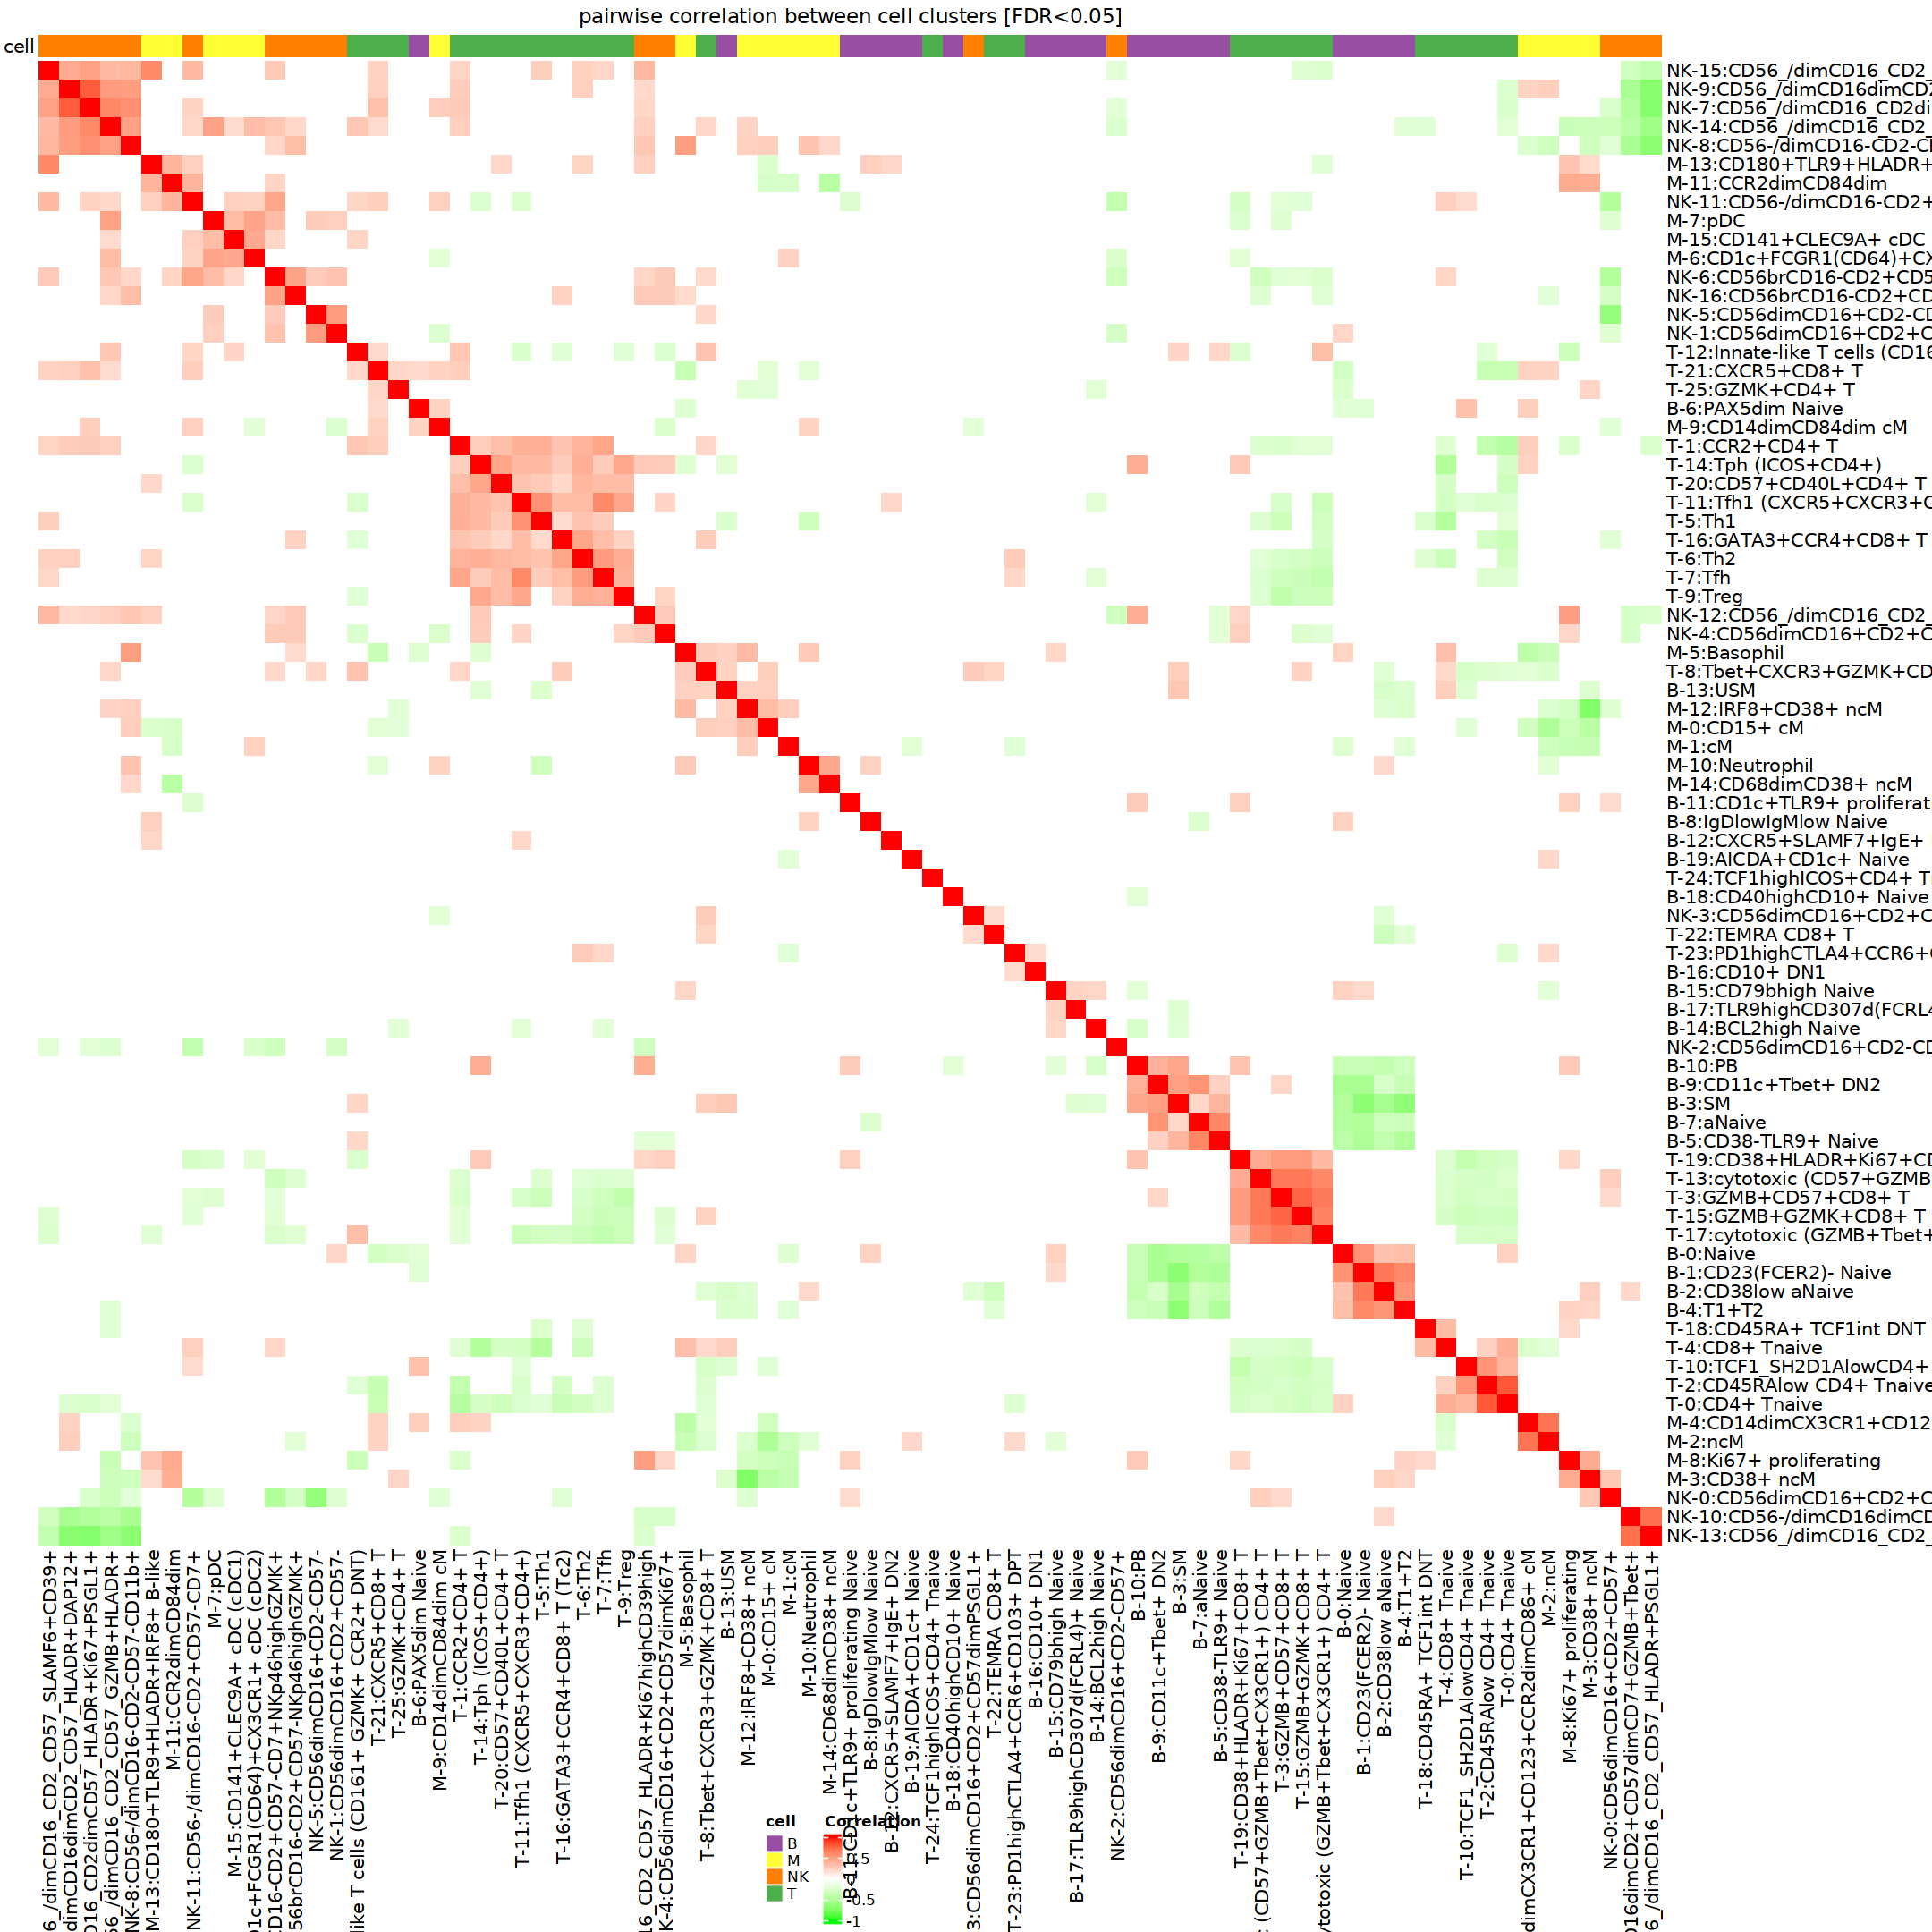

In [9]:

# all samples(V0+V1+V2)

# correlation among proportion of cell subpopulation

p_mat = Hmisc::rcorr(as.matrix(prop_mat),type="spearman")
padj_mat = tabletools::rcorr_padjust(p_mat, method = "BH")
rownames(padj_mat$r) = colnames(padj_mat$r) = rownames(padj_mat$P) = colnames(padj_mat$P) = cluster_df %>%
  dplyr::mutate(cluster_tmp=paste0(ifelse(cell=="M","myeloid",paste0(cell,"_cells")),"_cluster",cluster),
                clu_name = paste0(cell,"-",cluster,":",clu_name)) %>%
  tibble::column_to_rownames("cluster_tmp") %>%
  .[rownames(padj_mat$r),] %>%
  na.omit() %>% .$clu_name

options(repr.plot.height = 18, repr.plot.width = 18)
ht_list = Heatmap(replace(padj_mat$r, padj_mat$P>0.05, 0), 
                  top_annotation = ha, 
                  col = circlize::colorRamp2(c(-1, 0, 1), c("green", "white", "red")), 
                  show_row_names = TRUE, show_column_names = TRUE, 
                  show_row_dend = FALSE, 
                  show_column_dend = FALSE, 
                  column_title = "pairwise correlation between cell clusters [FDR<0.05]",
                  heatmap_legend_param = list(title = "Correlation"))
draw(ht_list,merge_legends = TRUE, heatmap_legend_side = "bottom")
